# Setting Up

In [1]:
import os
import re
import cv2
import time
import glob
import pickle
import Augmentor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import ceil

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import vgg16
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Input, BatchNormalization, Conv2D, AveragePooling2D, Dropout

from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

%matplotlib inline

C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\tfpose\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\tfpose\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\tfpose\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\RAJDEEP\Anaconda\Anaconda3\e

In [2]:
train_frac = 0.65
valid_frac = 0.35
train_bs = 32
valid_bs = 32

# Augmenting Images

In [3]:
p = Augmentor.Pipeline(source_directory = "./dataset_imgs", output_directory = "../augmented_imgs")

Initialised with 400 image(s) found.
Output directory set to ./dataset_imgs\../augmented_imgs.

In [4]:
p.rotate_without_crop(0.4, 30, 30, expand=True, fillcolor=None)
p.skew(0.5, 0.1)
p.shear(0.3,5,5)
p.flip_left_right(0.5)
p.random_contrast(0.4, 0.6, 1.4)
p.random_color(0.4, 0.6, 1.4)
p.random_brightness(0.4,0.5,1.5)

In [5]:
p.sample(3000)

Processing <PIL.Image.Image image mode=RGB size=476x335 at 0x118D97CFC18>: 100%|██████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:12<00:00, 41.20 Samples/s]


# Running the PoseEstimator

In [6]:
def pose_on_dir(input_folder, output_folder,
                model = "mobilenet_v2_large",
                resize = "432x368",
                resize_out_ratio = 4.0):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    w, h = model_wh(resize)
    if w == 0 or h == 0:
        e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
    else:
        e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))    
    files = glob.glob(os.path.join(input_folder, "*.jpg"))    
    imgs_poses_list = []    
    for f in files:
        img = cv2.imread(f)
        humans = e.inference(img, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
        image_with_pose_pts = TfPoseEstimator.draw_humans(img, humans, imgcopy=False)        
        imgs_poses_list.append(humans)
        filename = re.split(r"/|\\", f)[-1]
        cv2.imwrite(os.path.join(output_folder, filename), image_with_pose_pts)

    return files, imgs_poses_list

### Running over Images with Fighting

In [7]:
fighting_img_files, fighting_imgs_poses_list = pose_on_dir(input_folder = "./augmented_imgs/fighting",
                                                           output_folder = "./openpose_output_imgs/fighting")

[2020-09-24 14:54:38,601] [TfPoseEstimator] [INFO] loading graph from D:\tf-pose-estimation2\models\graph/mobilenet_v2_large/graph_opt.pb(default size=432x368)
2020-09-24 14:54:38,601 INFO loading graph from D:\tf-pose-estimation2\models\graph/mobilenet_v2_large/graph_opt.pb(default size=432x368)


2020-09-24 14:54:38,607 WARNING From D:\tf-pose-estimation2\tf_pose\estimator.py:311: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



2020-09-24 14:54:38,610 WARNING From D:\tf-pose-estimation2\tf_pose\estimator.py:312: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



2020-09-24 14:54:38,820 WARNING From D:\tf-pose-estimation2\tf_pose\estimator.py:330: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



2020-09-24 14:54:39,265 WARNING From D:\tf-pose-estimation2\tf_pose\estimator.py:332: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



TfPoseEstimator/image
TfPoseEstimator/MobilenetV2/Conv/BatchNorm/Const
TfPoseEstimator/MobilenetV2/Conv/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv/depthwise/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv/depthwise/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv/project/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv/project/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_1/expand/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv_1/expand/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_1/project/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv_1/project/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_2/expand/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv_2/expand/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_2/depthwise/

2020-09-24 14:54:44,075 WARNING From D:\tf-pose-estimation2\tf_pose\estimator.py:341: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2020-09-24 14:54:44,088 WARNING From D:\tf-pose-estimation2\tf_pose\estimator.py:342: The name tf.image.resize_area is deprecated. Please use tf.compat.v1.image.resize_area instead.



2020-09-24 14:54:44,112 WARNING From D:\tf-pose-estimation2\tf_pose\tensblur\smoother.py:96: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-09-24 14:54:44,147 WARNING From D:\tf-pose-estimation2\tf_pose\estimator.py:354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Running over Images with No Fighting

In [8]:
nonfighting_img_files, nonfighting_imgs_poses_list = pose_on_dir(input_folder = "./augmented_imgs/not_fighting",
                                                                 output_folder = "./openpose_output_imgs/not_fighting")

[2020-09-24 15:02:34,945] [TfPoseEstimator] [INFO] loading graph from D:\tf-pose-estimation2\models\graph/mobilenet_v2_large/graph_opt.pb(default size=432x368)
2020-09-24 15:02:34,945 INFO loading graph from D:\tf-pose-estimation2\models\graph/mobilenet_v2_large/graph_opt.pb(default size=432x368)


TfPoseEstimator/image
TfPoseEstimator/MobilenetV2/Conv/BatchNorm/Const
TfPoseEstimator/MobilenetV2/Conv/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv/depthwise/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv/depthwise/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv/project/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv/project/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_1/expand/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv_1/expand/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_1/project/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv_1/project/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_2/expand/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv_2/expand/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_2/depthwise/

### Concatenating

In [9]:
img_files = fighting_img_files + nonfighting_img_files

In [10]:
imgs_poses_list = fighting_imgs_poses_list + nonfighting_imgs_poses_list

### Removing the Pose Estimation Model from Memory

In [11]:
clear_session()

# Creating a CSV

In [12]:
df = pd.DataFrame(columns = ['AbsFilePath', 'FileName', 'Category', 'Fighting',
                             'H0P0 X', 'H0P0 Y', 'H0P0 S',
                             'H0P1 X', 'H0P1 Y', 'H0P1 S',
                             'H0P2 X', 'H0P2 Y', 'H0P2 S',
                             'H0P3 X', 'H0P3 Y', 'H0P3 S',
                             'H0P4 X', 'H0P4 Y', 'H0P4 S',
                             'H0P5 X', 'H0P5 Y', 'H0P5 S',
                             'H0P6 X', 'H0P6 Y', 'H0P6 S',
                             'H0P7 X', 'H0P7 Y', 'H0P7 S',
                             'H0P8 X', 'H0P8 Y', 'H0P8 S',
                             'H0P9 X', 'H0P9 Y', 'H0P9 S',
                             'H0P10 X', 'H0P10 Y', 'H0P10 S',
                             'H0P11 X', 'H0P11 Y', 'H0P11 S',
                             'H0P12 X', 'H0P12 Y', 'H0P12 S',
                             'H0P13 X', 'H0P13 Y', 'H0P13 S',
                             'H0P14 X', 'H0P14 Y', 'H0P14 S',
                             'H0P15 X', 'H0P15 Y', 'H0P15 S',
                             'H0P16 X', 'H0P16 Y', 'H0P16 S',
                             'H0P17 X', 'H0P17 Y', 'H0P17 S',

                             'H1P0 X', 'H1P0 Y', 'H1P0 S',
                             'H1P1 X', 'H1P1 Y', 'H1P1 S',
                             'H1P2 X', 'H1P2 Y', 'H1P2 S',
                             'H1P3 X', 'H1P3 Y', 'H1P3 S',
                             'H1P4 X', 'H1P4 Y', 'H1P4 S',
                             'H1P5 X', 'H1P5 Y', 'H1P5 S',
                             'H1P6 X', 'H1P6 Y', 'H1P6 S',
                             'H1P7 X', 'H1P7 Y', 'H1P7 S',
                             'H1P8 X', 'H1P8 Y', 'H1P8 S',
                             'H1P9 X', 'H1P9 Y', 'H1P9 S',
                             'H1P10 X', 'H1P10 Y', 'H1P10 S',
                             'H1P11 X', 'H1P11 Y', 'H1P11 S',
                             'H1P12 X', 'H1P12 Y', 'H1P12 S',
                             'H1P13 X', 'H1P13 Y', 'H1P13 S',
                             'H1P14 X', 'H1P14 Y', 'H1P14 S',
                             'H1P15 X', 'H1P15 Y', 'H1P15 S',
                             'H1P16 X', 'H1P16 Y', 'H1P16 S',
                             'H1P17 X', 'H1P17 Y', 'H1P17 S'])

df['AbsFilePath'] = img_files
print(df.shape)
df.head()                            

(2984, 112)


,AbsFilePath,FileName,Category,Fighting,H0P0 X,H0P0 Y,H0P0 S,H0P1 X,H0P1 Y,H0P1 S,...,H1P14 S,H1P15 X,H1P15 Y,H1P15 S,H1P16 X,H1P16 Y,H1P16 S,H1P17 X,H1P17 Y,H1P17 S
0,./augmented_imgs/fighting\fighting_original_1 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,./augmented_imgs/fighting\fighting_original_1 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,./augmented_imgs/fighting\fighting_original_1 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,./augmented_imgs/fighting\fighting_original_1 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,./augmented_imgs/fighting\fighting_original_1 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filling the Pose Points Info

(Fighting = 0, NotFighting = 0)

In [13]:
for i,f in enumerate(img_files):
    df.iloc[i]['FileName'] = re.split(r"/|\\", f)[-1]
    df.iloc[i]['Category'] = re.split(r"/|\\", f)[-2]
    df.iloc[i]['Fighting'] = (0 if re.split(r"/|\\", f)[-2]=='fighting' else 1)
    single_img_poses = imgs_poses_list[i]
    for h,human in enumerate(single_img_poses[:2]):
        for item in human.body_parts.items():
            part_id = item[0]
            body_part = item[1]
            mapping = "H{0}P{1} ".format(h,part_id)
            mappingX = mapping + 'X'
            mappingY = mapping + 'Y'
            mappingS = mapping + 'S'
            df.iloc[i][mappingX] = body_part.x
            df.iloc[i][mappingY] = body_part.y
            df.iloc[i][mappingS] = body_part.score

df

,AbsFilePath,FileName,Category,Fighting,H0P0 X,H0P0 Y,H0P0 S,H0P1 X,H0P1 Y,H0P1 S,...,H1P14 S,H1P15 X,H1P15 Y,H1P15 S,H1P16 X,H1P16 Y,H1P16 S,H1P17 X,H1P17 Y,H1P17 S
0,./augmented_imgs/fighting\fighting_original_1 ...,fighting_original_1 (2).jpg_0484eae3-77c3-4bd8...,fighting,0,0.314815,0.211957,0.758893,0.240741,0.282609,0.706579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,./augmented_imgs/fighting\fighting_original_1 ...,fighting_original_1 (2).jpg_048ee8b5-3e4e-4093...,fighting,0,0.328704,0.271739,0.80975,0.240741,0.342391,0.637528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,./augmented_imgs/fighting\fighting_original_1 ...,fighting_original_1 (2).jpg_4b61a50a-a013-472f...,fighting,0,0.819444,0.255435,0.776788,0.851852,0.38587,0.309999,...,0.353947,0.287037,0.108696,0.136225,0.231481,0.0923913,0.518298,NaN,NaN,NaN
3,./augmented_imgs/fighting\fighting_original_1 ...,fighting_original_1 (2).jpg_6d16ba81-dcfc-4b9c...,fighting,0,0.791667,0.277174,0.769757,0.814815,0.478261,0.211756,...,0.429297,NaN,NaN,NaN,0.208333,0.0597826,0.520115,NaN,NaN,NaN
4,./augmented_imgs/fighting\fighting_original_1 ...,fighting_original_1 (2).jpg_a1910838-71f5-4ce1...,fighting,0,0.601852,0.184783,0.441071,0.680556,0.233696,0.385861,...,0.496083,NaN,NaN,NaN,0.171296,0.543478,0.5389,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2979,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_x9.jpg_71001ac0-85de-4e2...,not_fighting,1,0.569444,0.255435,0.757166,0.574074,0.304348,0.728401,...,0.76508,0.74537,0.369565,0.873755,0.703704,0.369565,0.178658,0.773148,0.380435,0.783017
2980,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_x9.jpg_a9a935e3-6dbe-471...,not_fighting,1,0.564815,0.271739,0.868946,0.569444,0.320652,0.759254,...,0.838365,0.717593,0.391304,0.81129,0.675926,0.380435,0.152492,0.740741,0.407609,0.774946
2981,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_x9.jpg_b4a108cb-cd8b-4ed...,not_fighting,1,0.375,0.23913,0.805344,0.416667,0.282609,0.718749,...,0.795603,0.740741,0.288043,0.840174,NaN,NaN,NaN,0.796296,0.282609,0.725776
2982,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_x9.jpg_d9e0a5ac-ced6-41b...,not_fighting,1,0.583333,0.282609,0.759904,0.550926,0.331522,0.717115,...,0.793369,0.282407,0.358696,0.86381,0.189815,0.347826,0.682206,0.310185,0.36413,0.124545


### Filling NaNs with Zero

In [14]:
df.fillna(0, inplace=True)

### Shuffling the DataFrame

In [15]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,AbsFilePath,FileName,Category,Fighting,H0P0 X,H0P0 Y,H0P0 S,H0P1 X,H0P1 Y,H0P1 S,...,H1P14 S,H1P15 X,H1P15 Y,H1P15 S,H1P16 X,H1P16 Y,H1P16 S,H1P17 X,H1P17 Y,H1P17 S
0,./augmented_imgs/fighting\fighting_original_ge...,fighting_original_gettyimages-1143996190-2048x...,fighting,0,0.537037,0.326087,0.439975,0.643519,0.456522,0.669361,...,0.868362,0.000000,0.000000,0.000000,0.268519,0.23913,0.789077,0.000000,0.000000,0.000000
1,./augmented_imgs/fighting\fighting_original_66...,fighting_original_66.jpg_a97ad6ae-57de-431b-80...,fighting,0,0.305556,0.358696,0.784138,0.300926,0.467391,0.745748,...,0.637423,0.537037,0.211957,0.762368,0.000000,0.00000,0.000000,0.583333,0.190217,0.788769
2,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_x14.jpg_063940c1-efdc-43...,not_fighting,1,0.226852,0.184783,0.781464,0.296296,0.271739,0.667184,...,0.000000,0.750000,0.130435,0.125498,0.000000,0.00000,0.000000,0.814815,0.163043,0.393382
3,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_best-friends-having-picn...,not_fighting,1,0.430556,0.201087,0.852023,0.462963,0.304348,0.647602,...,0.819565,0.000000,0.000000,0.000000,0.185185,0.23913,0.747671,0.000000,0.000000,0.000000
4,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_x35.jpg_64b7700e-406c-4a...,not_fighting,1,0.101852,0.347826,0.835361,0.212963,0.451087,0.723636,...,0.577143,0.657407,0.347826,0.822086,0.000000,0.00000,0.000000,0.750000,0.358696,0.845269


# Splitting into Train and Validation Data

In [16]:
n = df.shape[0]

In [17]:
train_df = df[:int(train_frac * n)]
valid_df = df[int(train_frac * n):]
print(train_df.shape)
print(valid_df.shape)

(1939, 112)
(1045, 112)


In [18]:
train_df.head()

,AbsFilePath,FileName,Category,Fighting,H0P0 X,H0P0 Y,H0P0 S,H0P1 X,H0P1 Y,H0P1 S,...,H1P14 S,H1P15 X,H1P15 Y,H1P15 S,H1P16 X,H1P16 Y,H1P16 S,H1P17 X,H1P17 Y,H1P17 S
0,./augmented_imgs/fighting\fighting_original_ge...,fighting_original_gettyimages-1143996190-2048x...,fighting,0,0.537037,0.326087,0.439975,0.643519,0.456522,0.669361,...,0.868362,0.000000,0.000000,0.000000,0.268519,0.23913,0.789077,0.000000,0.000000,0.000000
1,./augmented_imgs/fighting\fighting_original_66...,fighting_original_66.jpg_a97ad6ae-57de-431b-80...,fighting,0,0.305556,0.358696,0.784138,0.300926,0.467391,0.745748,...,0.637423,0.537037,0.211957,0.762368,0.000000,0.00000,0.000000,0.583333,0.190217,0.788769
2,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_x14.jpg_063940c1-efdc-43...,not_fighting,1,0.226852,0.184783,0.781464,0.296296,0.271739,0.667184,...,0.000000,0.750000,0.130435,0.125498,0.000000,0.00000,0.000000,0.814815,0.163043,0.393382
3,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_best-friends-having-picn...,not_fighting,1,0.430556,0.201087,0.852023,0.462963,0.304348,0.647602,...,0.819565,0.000000,0.000000,0.000000,0.185185,0.23913,0.747671,0.000000,0.000000,0.000000
4,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_x35.jpg_64b7700e-406c-4a...,not_fighting,1,0.101852,0.347826,0.835361,0.212963,0.451087,0.723636,...,0.577143,0.657407,0.347826,0.822086,0.000000,0.00000,0.000000,0.750000,0.358696,0.845269


In [19]:
valid_df.head()

,AbsFilePath,FileName,Category,Fighting,H0P0 X,H0P0 Y,H0P0 S,H0P1 X,H0P1 Y,H0P1 S,...,H1P14 S,H1P15 X,H1P15 Y,H1P15 S,H1P16 X,H1P16 Y,H1P16 S,H1P17 X,H1P17 Y,H1P17 S
1939,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_stock-photo-two-people-s...,not_fighting,1,0.319444,0.375000,0.859608,0.277778,0.467391,0.760204,...,0.692112,0.481481,0.288043,0.810552,0.000000,0.000000,0.000000,0.513889,0.260870,0.729290
1940,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_90.jpg_f39d7ba3-cd78-4db...,not_fighting,1,0.379630,0.396739,0.823454,0.356481,0.516304,0.336299,...,0.749880,0.592593,0.418478,0.789417,0.000000,0.000000,0.000000,0.634259,0.461957,0.625968
1941,./augmented_imgs/fighting\fighting_original_Ar...,fighting_original_ArcticSaneHeifer-mobile.jpg_...,fighting,0,0.333333,0.326087,0.659187,0.282407,0.347826,0.821906,...,0.136001,0.513889,0.472826,0.389840,0.000000,0.000000,0.000000,0.523148,0.478261,0.509120
1942,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_91.jpg_3b5c59b1-f6e2-436...,not_fighting,1,0.453704,0.282609,0.785527,0.324074,0.380435,0.672488,...,0.828093,0.763889,0.228261,0.804891,0.620370,0.255435,0.589645,0.847222,0.217391,0.726075
1943,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_depositphotos_147103679-...,not_fighting,1,0.240741,0.298913,0.712975,0.185185,0.538043,0.373883,...,0.844645,0.370370,0.342391,0.775961,0.268519,0.391304,0.788356,0.000000,0.000000,0.000000


# Standardising the Data

In [20]:
scaler = StandardScaler()

In [21]:
train_df[train_df.columns[4:]] = scaler.fit_transform(train_df[train_df.columns[4:]])
train_df.head()

C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\tfpose\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\tfpose\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,AbsFilePath,FileName,Category,Fighting,H0P0 X,H0P0 Y,H0P0 S,H0P1 X,H0P1 Y,H0P1 S,...,H1P14 S,H1P15 X,H1P15 Y,H1P15 S,H1P16 X,H1P16 Y,H1P16 S,H1P17 X,H1P17 Y,H1P17 S
0,./augmented_imgs/fighting\fighting_original_ge...,fighting_original_gettyimages-1143996190-2048x...,fighting,0,0.396068,0.322514,-0.885265,0.780362,0.506787,0.316345,...,1.208283,-1.201573,-1.172096,-1.244004,0.371583,0.565496,1.513999,-0.916327,-0.880776,-0.889572
1,./augmented_imgs/fighting\fighting_original_66...,fighting_original_66.jpg_a97ad6ae-57de-431b-80...,fighting,0,-0.623413,0.558186,0.447667,-0.681248,0.577366,0.645773,...,0.563763,0.605817,0.078699,0.854010,-0.782138,-0.828772,-0.830453,0.818828,0.216193,1.405767
2,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_x14.jpg_063940c1-efdc-43...,not_fighting,1,-0.970037,-0.698730,0.437313,-0.701000,-0.693043,0.306956,...,-1.215196,1.322540,-0.402376,-0.898636,-0.782138,-0.828772,-0.830453,1.507382,0.059483,0.255180
3,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_best-friends-having-picn...,not_fighting,1,-0.072894,-0.580894,0.710586,0.010054,-0.481308,0.222510,...,1.072095,-1.201573,-1.172096,-1.244004,0.013531,0.565496,1.390974,-0.916327,-0.880776,-0.889572
4,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_x35.jpg_64b7700e-406c-4a...,not_fighting,1,-1.520557,0.479628,0.646051,-1.056526,0.471498,0.550414,...,0.395528,1.010921,0.880490,1.018352,-0.782138,-0.828772,-0.830453,1.314587,1.187795,1.570185


In [22]:
valid_df[valid_df.columns[4:]] = scaler.transform(valid_df[valid_df.columns[4:]])
valid_df.head()

C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\tfpose\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\tfpose\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,AbsFilePath,FileName,Category,Fighting,H0P0 X,H0P0 Y,H0P0 S,H0P1 X,H0P1 Y,H0P1 S,...,H1P14 S,H1P15 X,H1P15 Y,H1P15 S,H1P16 X,H1P16 Y,H1P16 S,H1P17 X,H1P17 Y,H1P17 S
1939,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_stock-photo-two-people-s...,not_fighting,1,-0.562245,0.676021,0.739962,-0.780006,0.577366,0.708120,...,0.716392,0.418845,0.527702,0.986612,-0.782138,-0.828772,-0.830453,0.612262,0.623639,1.232681
1940,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_90.jpg_f39d7ba3-cd78-4db...,not_fighting,1,-0.297180,0.833136,0.599937,-0.444230,0.894968,-1.120021,...,0.877614,0.792788,1.297422,0.928449,-0.782138,-0.828772,-0.830453,0.970310,1.783292,0.932013
1941,./augmented_imgs/fighting\fighting_original_Ar...,fighting_original_ArcticSaneHeifer-mobile.jpg_...,fighting,0,-0.501076,0.322514,-0.036263,-0.760254,-0.198995,0.974215,...,-0.835636,0.527912,1.618138,-0.171177,-0.782138,-0.828772,-0.830453,0.639804,1.877318,0.591982
1942,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_91.jpg_3b5c59b1-f6e2-436...,not_fighting,1,0.029054,0.008285,0.453048,-0.582491,0.012740,0.329830,...,1.095897,1.369283,0.174914,0.971032,1.883355,0.660559,0.921459,1.603780,0.372903,1.223327
1943,./augmented_imgs/not_fighting\not_fighting_ori...,not_fighting_original_depositphotos_147103679-...,not_fighting,1,-0.908868,0.126121,0.172054,-1.175035,1.036124,-0.957938,...,1.142089,0.044903,0.848419,0.891418,0.371583,1.452757,1.511856,-0.916327,-0.880776,-0.889572


# Saving the Train and Valid Dataframes

In [23]:
train_df.to_csv("TrainPosePoints.csv", index = False)

In [24]:
valid_df.to_csv("ValidPosePoints.csv", index = False)

# Separating Input Features and Ground Truth Labels from the Dataframes

In [25]:
X_train = train_df.drop(["AbsFilePath", "FileName", "Category", "Fighting"], axis = 1)
y_train = train_df["Fighting"]
print(X_train.shape)
print(y_train.shape)

(1939, 108)
(1939,)


In [26]:
X_valid = valid_df.drop(["AbsFilePath", "FileName", "Category", "Fighting"], axis = 1)
y_valid = valid_df["Fighting"]
print(X_valid.shape)
print(y_valid.shape)

(1045, 108)
(1045,)


# Creating folders to save Models and related Images

In [27]:
saved_models_path = "saved_models"
if not os.path.exists(saved_models_path):
    os.makedirs(saved_models_path)

In [28]:
imgs_path = "models_info_imgs"
if not os.path.exists(imgs_path):
    os.makedirs(imgs_path)

**Now, we will be creating models. We initially create 3 models that take only the Pose Points as input - SVM, Logistic Classifer and a Neural Network. After that, we are gonna take VGG16, remove its top layers and concatenate our Pose Points with its output before connecting it to a Neural Network. Our motive is to check, how passing the image itself and allowing VGG16 to extract features from it would help to classify the images alongside the Pose Points.**

# SVM (Pose Points)

In [29]:
svm_clf = SVC(kernel = 'rbf', degree = 3, random_state = 42)

In [30]:
svm_clf.fit(X_train, y_train)

SVC(random_state=42)

In [31]:
y_train_pred = svm_clf.predict(X_train)
y_valid_pred = svm_clf.predict(X_valid)

In [32]:
svm_train_acc = metrics.accuracy_score(y_train, y_train_pred)
svm_valid_acc = metrics.accuracy_score(y_valid, y_valid_pred)
print("Training Accuracy:", svm_train_acc)
print("Validation Accuracy:", svm_valid_acc) 

Training Accuracy: 0.9546157813305828
Validation Accuracy: 0.8937799043062201


In [33]:
print("F1 Score:", metrics.f1_score(y_valid, y_valid_pred))

F1 Score: 0.8875379939209727


In [34]:
pickle.dump(svm_clf, open(os.path.join(saved_models_path,'svm_model'), 'wb'))

# Logistic Regressor (Pose Points)

In [35]:
log_reg = Sequential()
log_reg.add(Dense(1, activation = 'sigmoid', input_shape = (len(X_train.columns),)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-09-24 15:10:24,330 WARNING From C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\tfpose\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [36]:
log_reg.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [37]:
lg_hist = log_reg.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Train on 1939 samples, validate on 1045 samples
Epoch 1/100
1939/1939 [==============================] - 1s 486us/sample - loss: 0.7323 - acc: 0.6050 - val_loss: 0.6911 - val_acc: 0.6392
Epoch 2/100
1939/1939 [==============================] - 0s 69us/sample - loss: 0.6489 - acc: 0.6653 - val_loss: 0.6298 - val_acc: 0.6794
Epoch 3/100
1939/1939 [==============================] - 0s 69us/sample - loss: 0.5991 - acc: 0.6962 - val_loss: 0.5896 - val_acc: 0.7072
Epoch 4/100
1939/1939 [==============================] - 0s 69us/sample - loss: 0.5619 - acc: 0.7246 - val_loss: 0.5571 - val_acc: 0.7359
Epoch 5/100
1939/1939 [==============================] - 0s 70us/sample - loss: 0.5350 - acc: 0.7483 - val_loss: 0.5371 - val_acc: 0.7502
Epoch 6/100
1939/1939 [==============================] - 0s 72us/sample - loss: 0.5137 - acc: 0.7617 - val_loss: 0.5173 - val_acc: 0.7636
Epoch 7/100
1939/1939 [==============================] - 0s 73us/sample - loss: 0.4971 - acc: 0.7751 - val_loss: 0.5026 - v

1939/1939 [==============================] - 0s 84us/sample - loss: 0.3633 - acc: 0.8520 - val_loss: 0.3913 - val_acc: 0.8278
Epoch 60/100
1939/1939 [==============================] - 0s 78us/sample - loss: 0.3616 - acc: 0.8525 - val_loss: 0.3908 - val_acc: 0.8287
Epoch 61/100
1939/1939 [==============================] - 0s 81us/sample - loss: 0.3615 - acc: 0.8499 - val_loss: 0.3918 - val_acc: 0.8297
Epoch 62/100
1939/1939 [==============================] - 0s 79us/sample - loss: 0.3608 - acc: 0.8546 - val_loss: 0.3903 - val_acc: 0.8297
Epoch 63/100
1939/1939 [==============================] - 0s 79us/sample - loss: 0.3603 - acc: 0.8494 - val_loss: 0.3901 - val_acc: 0.8268
Epoch 64/100
1939/1939 [==============================] - 0s 79us/sample - loss: 0.3598 - acc: 0.8525 - val_loss: 0.3906 - val_acc: 0.8316
Epoch 65/100
1939/1939 [==============================] - 0s 76us/sample - loss: 0.3595 - acc: 0.8530 - val_loss: 0.3893 - val_acc: 0.8249
Epoch 66/100
1939/1939 [================

In [38]:
log_reg.save(os.path.join(saved_models_path,"logistic_regressor.h5"))

# Basic Neural Network (Pose Points)

In [39]:
nn = Sequential()
nn.add(Dense(10, activation = 'relu', input_shape = (len(X_train.columns),)))
nn.add(BatchNormalization())
nn.add(Dense(5, activation = 'relu'))
nn.add(BatchNormalization())
nn.add(Dense(2, activation = 'relu'))
nn.add(Dense(1, activation = 'sigmoid'))

In [40]:
nn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [41]:
nn_hist = nn.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Train on 1939 samples, validate on 1045 samples
Epoch 1/100
1939/1939 [==============================] - 1s 309us/sample - loss: 0.7278 - acc: 0.5647 - val_loss: 0.6592 - val_acc: 0.6392
Epoch 2/100
1939/1939 [==============================] - 0s 178us/sample - loss: 0.6269 - acc: 0.6658 - val_loss: 0.6360 - val_acc: 0.6766
Epoch 3/100
1939/1939 [==============================] - 0s 172us/sample - loss: 0.5948 - acc: 0.7303 - val_loss: 0.6137 - val_acc: 0.7024
Epoch 4/100
1939/1939 [==============================] - 0s 176us/sample - loss: 0.5709 - acc: 0.7602 - val_loss: 0.5953 - val_acc: 0.7282
Epoch 5/100
1939/1939 [==============================] - 0s 176us/sample - loss: 0.5565 - acc: 0.7741 - val_loss: 0.5784 - val_acc: 0.7435
Epoch 6/100
1939/1939 [==============================] - 0s 174us/sample - loss: 0.5363 - acc: 0.7947 - val_loss: 0.5661 - val_acc: 0.7541
Epoch 7/100
1939/1939 [==============================] - 0s 169us/sample - loss: 0.5113 - acc: 0.8133 - val_loss: 0.55

1939/1939 [==============================] - 0s 175us/sample - loss: 0.1819 - acc: 0.9443 - val_loss: 0.3568 - val_acc: 0.8766
Epoch 60/100
1939/1939 [==============================] - 0s 176us/sample - loss: 0.1622 - acc: 0.9572 - val_loss: 0.3598 - val_acc: 0.8737
Epoch 61/100
1939/1939 [==============================] - 0s 184us/sample - loss: 0.1814 - acc: 0.9464 - val_loss: 0.3513 - val_acc: 0.8766
Epoch 62/100
1939/1939 [==============================] - 0s 171us/sample - loss: 0.1735 - acc: 0.9495 - val_loss: 0.3603 - val_acc: 0.8766
Epoch 63/100
1939/1939 [==============================] - 0s 176us/sample - loss: 0.1673 - acc: 0.9510 - val_loss: 0.3690 - val_acc: 0.8746
Epoch 64/100
1939/1939 [==============================] - 0s 168us/sample - loss: 0.1741 - acc: 0.9495 - val_loss: 0.3613 - val_acc: 0.8708
Epoch 65/100
1939/1939 [==============================] - 0s 173us/sample - loss: 0.1889 - acc: 0.9381 - val_loss: 0.3578 - val_acc: 0.8813
Epoch 66/100
1939/1939 [=========

In [42]:
nn.save(os.path.join(saved_models_path,"neural_network.h5"))

# Creating Datagenerators for subsequent Models

In [43]:
datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input)

In [44]:
def pp_gen(df, bs):    
    arr = np.array(df.drop(['AbsFilePath', 'FileName', 'Category', 'Fighting'], axis=1))
    l = ceil(arr.shape[0]/bs)
    while True:
        for i in range(l):
            yield((arr[i*bs:(i+1)*bs]))

In [45]:
def create_generators(df, bs):
    img_generator = datagen.flow_from_dataframe(df,
                                                directory = None,
                                                x_col = 'AbsFilePath',
                                                y_col = 'Category',
                                                target_size = (224,224),
                                                class_mode = 'binary',
                                                seed = 42,
                                                batch_size = bs,
                                                shuffle = False)
    pose_pts_generator = pp_gen(df, bs)
    while True:
        X1 = next(img_generator)
        X2 = next(pose_pts_generator)
        yield ([X1[0],X2],X1[1])

In [46]:
train_gen = create_generators(train_df, train_bs)
valid_gen = create_generators(valid_df, valid_bs)

# CNN + Pose Points

### Starting with the pretrained VGG16

In [47]:
vgg16_model = vgg16.VGG16(include_top = False, input_shape = (224,224,3), classes = 2)

In [48]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Creating the Custom Model

In [49]:
f = AveragePooling2D(pool_size = (7,7), padding = 'valid')(vgg16_model.output)
f = Flatten()(f)
f = BatchNormalization()(f)
x2 = Input(shape = (108,))
t = Concatenate(axis=-1)([f,x2])
t = Dense(10, activation = 'relu')(t)
t = Dropout(0.5)(t)
t = Dense(5, activation = 'relu')(t)
t = Dense(1, activation = 'sigmoid')(t)

In [50]:
vgg16nn = Model(inputs = [vgg16_model.input, x2], outputs = [t])
vgg16nn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

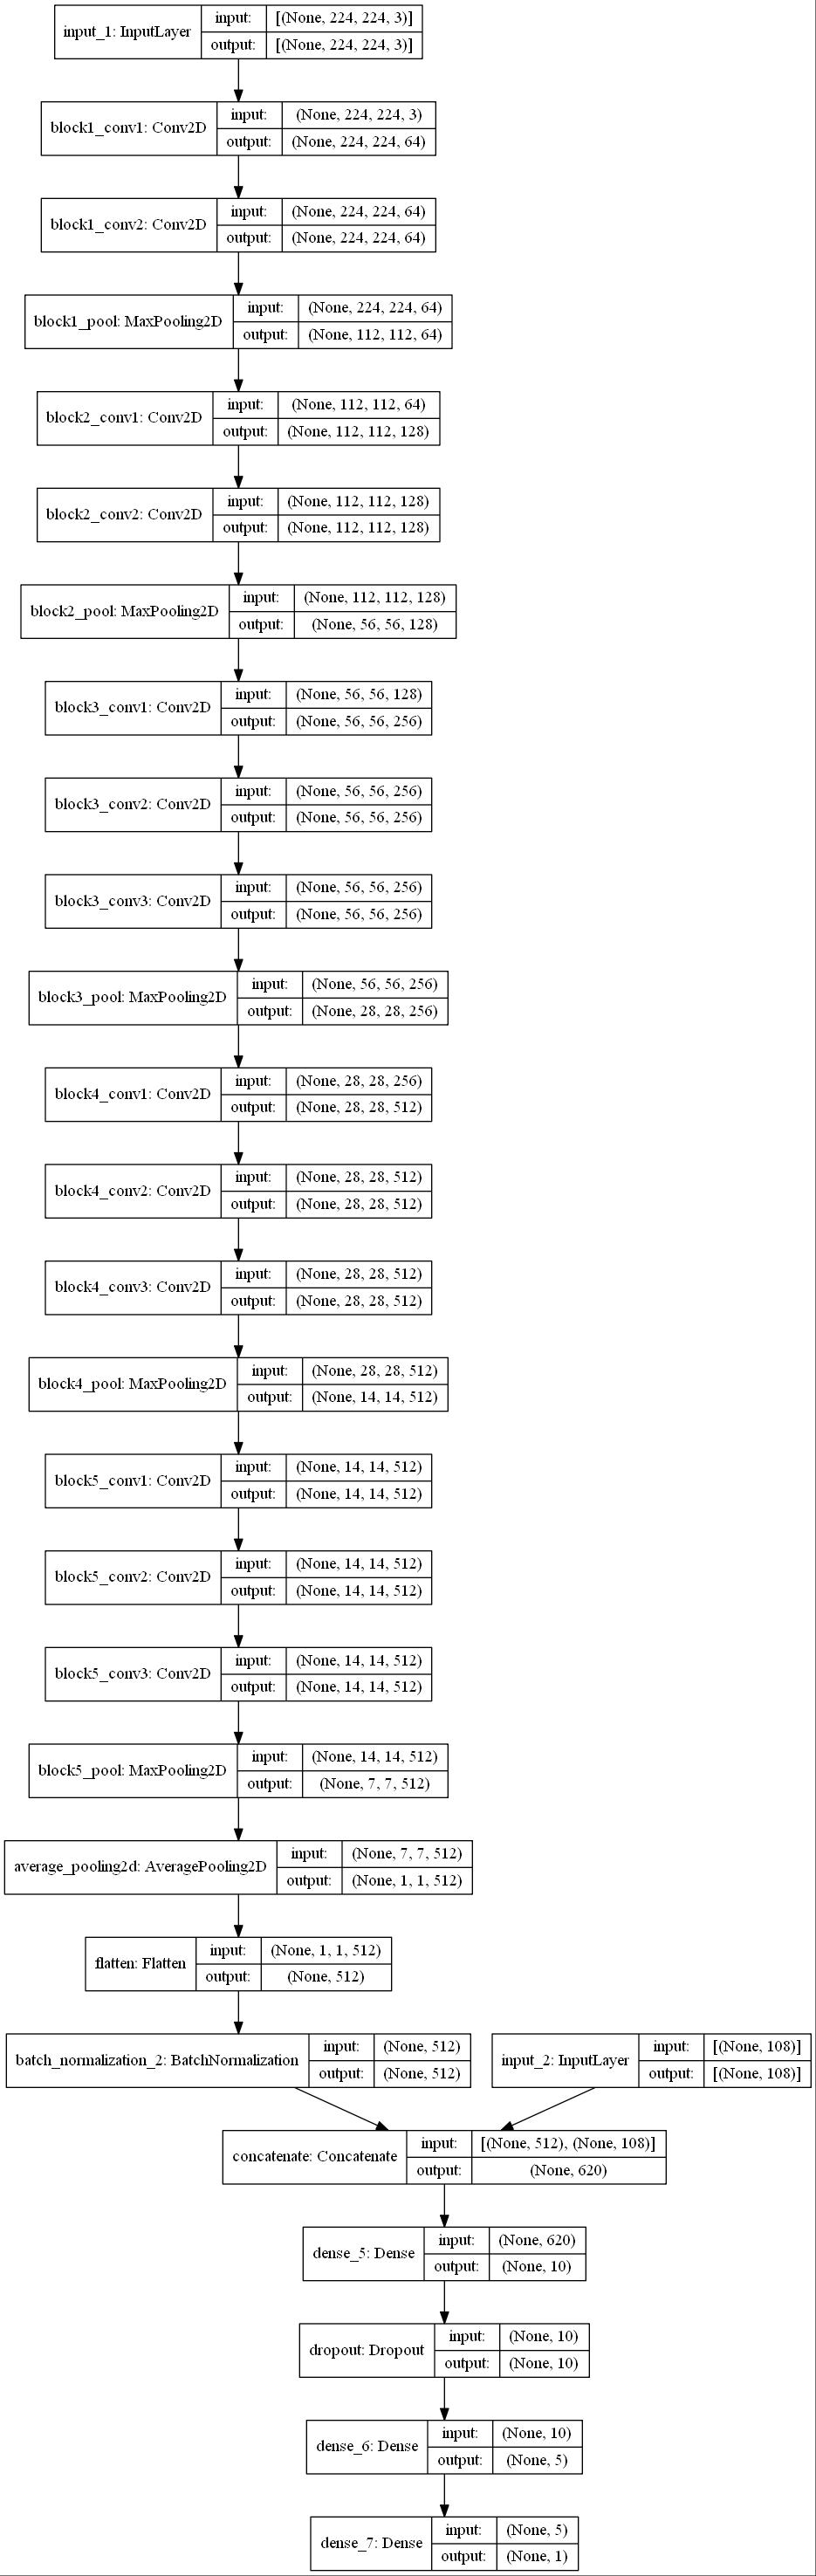

In [51]:
plot_model(vgg16nn, to_file=os.path.join(imgs_path,"vgg16nn.jpg"), show_shapes=True)

### Freezing the VGG16 Part

In [52]:
vgg16_model.trainable = False 
for i in vgg16nn.layers:
    print(i.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True


### Compiling the Model

In [53]:
optim = Adam(lr = 0.001)
vgg16nn.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = ['accuracy'])

### Training the Model

In [54]:
vgg16nn_hist_pf = vgg16nn.fit_generator(train_gen,
                             steps_per_epoch = ceil(train_df.shape[0]/train_bs),
                             epochs = 20,
                             validation_data = valid_gen,
                             verbose = 2,
                             validation_steps = ceil(valid_df.shape[0]/valid_bs),
                             validation_freq = 1
                             )

Found 1939 validated image filenames belonging to 2 classes.
Epoch 1/20
Found 1045 validated image filenames belonging to 2 classes.
61/61 - 17s - loss: 0.5674 - acc: 0.6978 - val_loss: 0.3809 - val_acc: 0.8651
Epoch 2/20
61/61 - 12s - loss: 0.3755 - acc: 0.8025 - val_loss: 0.2497 - val_acc: 0.9330
Epoch 3/20
61/61 - 13s - loss: 0.3031 - acc: 0.8546 - val_loss: 0.1775 - val_acc: 0.9493
Epoch 4/20
61/61 - 13s - loss: 0.2421 - acc: 0.9041 - val_loss: 0.1352 - val_acc: 0.9569
Epoch 5/20
61/61 - 15s - loss: 0.1861 - acc: 0.9268 - val_loss: 0.1079 - val_acc: 0.9656
Epoch 6/20
61/61 - 13s - loss: 0.1737 - acc: 0.9293 - val_loss: 0.0881 - val_acc: 0.9713
Epoch 7/20
61/61 - 13s - loss: 0.1261 - acc: 0.9505 - val_loss: 0.0770 - val_acc: 0.9742
Epoch 8/20
61/61 - 13s - loss: 0.1107 - acc: 0.9654 - val_loss: 0.0673 - val_acc: 0.9780
Epoch 9/20
61/61 - 13s - loss: 0.1055 - acc: 0.9567 - val_loss: 0.0629 - val_acc: 0.9742
Epoch 10/20
61/61 - 13s - loss: 0.0845 - acc: 0.9701 - val_loss: 0.0579 - val

### Saving Pre-Finetuned Model

In [55]:
vgg16nn.save(os.path.join(saved_models_path,"prefinetuned_VGG16nn.h5"))

### Unfreezing the Entire Model

In [56]:
vgg16nn.trainable = True
for i in vgg16nn.layers:
    print(i.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### Finetuning the Model

In [57]:
optim = Adam(lr = 0.000001)
vgg16nn.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [58]:
vgg16nn_hist_f = vgg16nn.fit_generator(train_gen,
                             steps_per_epoch = ceil(train_df.shape[0]/train_bs),
                             epochs = 100,
                             validation_data = valid_gen,
                             verbose = 2,
                             validation_steps = ceil(valid_df.shape[0]/valid_bs),
                             validation_freq = 1,
                             initial_epoch = 20,
                             callbacks = [EarlyStopping(monitor = 'val_loss',
                                                        patience = 5,
                                                        restore_best_weights = True)]        
                             )

Epoch 21/100
61/61 - 30s - loss: 0.0424 - acc: 0.9830 - val_loss: 0.0437 - val_acc: 0.9828
Epoch 22/100
61/61 - 24s - loss: 0.0435 - acc: 0.9819 - val_loss: 0.0415 - val_acc: 0.9837
Epoch 23/100
61/61 - 23s - loss: 0.0366 - acc: 0.9887 - val_loss: 0.0399 - val_acc: 0.9847
Epoch 24/100
61/61 - 23s - loss: 0.0363 - acc: 0.9856 - val_loss: 0.0385 - val_acc: 0.9856
Epoch 25/100
61/61 - 23s - loss: 0.0368 - acc: 0.9881 - val_loss: 0.0383 - val_acc: 0.9856
Epoch 26/100
61/61 - 24s - loss: 0.0358 - acc: 0.9881 - val_loss: 0.0360 - val_acc: 0.9866
Epoch 27/100
61/61 - 23s - loss: 0.0383 - acc: 0.9866 - val_loss: 0.0320 - val_acc: 0.9866
Epoch 28/100
61/61 - 23s - loss: 0.0280 - acc: 0.9917 - val_loss: 0.0328 - val_acc: 0.9866
Epoch 29/100
61/61 - 23s - loss: 0.0324 - acc: 0.9881 - val_loss: 0.0294 - val_acc: 0.9876
Epoch 30/100
61/61 - 23s - loss: 0.0319 - acc: 0.9876 - val_loss: 0.0297 - val_acc: 0.9876
Epoch 31/100
61/61 - 23s - loss: 0.0317 - acc: 0.9871 - val_loss: 0.0303 - val_acc: 0.9866

### Saving the Model

In [59]:
vgg16nn.save(os.path.join(saved_models_path,"finetuned_VGG16nn.h5"))

# Comparing the Keras Models

In [60]:
hist_objs = [lg_hist, nn_hist, vgg16nn_hist_pf, vgg16nn_hist_f]
colours = ['r-', 'g-', 'b-', 'b-']

In [61]:
x1 = [i for i in range(100)]
x2 = [i for i in range(20)]

In [62]:
l = len(vgg16nn_hist_f.history['val_loss'])
x3 = [i for i in range(19, 19+l)]

### Plotting Train Accuracy

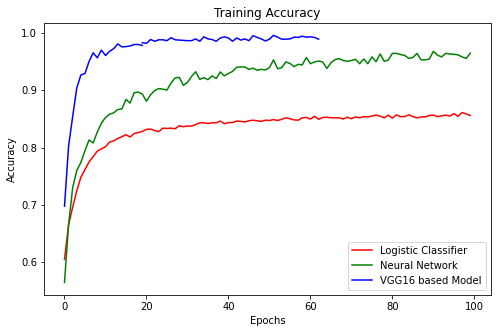

In [63]:
train_acc_fig = plt.figure(figsize = (8,5))
for i, (hist, colour) in enumerate(zip(hist_objs, colours)):        
    y = hist.history['acc']
    if (i==2):
        plt.plot(x2, y, colour)
    elif (i==3):
        plt.plot(x3, y, colour)
    else:
        plt.plot(x1, y, colour)
plt.title("Training Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Logistic Classifier', 'Neural Network', 'VGG16 based Model'], loc='lower right')
plt.show()

### Plotting Validation Accuracy

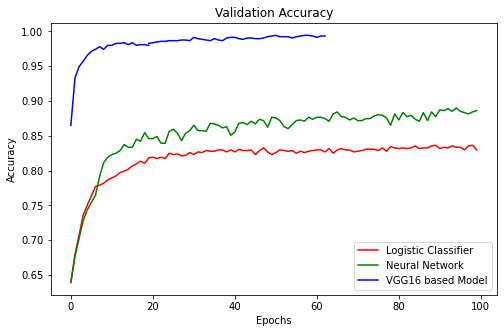

In [64]:
val_acc_fig = plt.figure(figsize = (8,5))
for i, (hist, colour) in enumerate(zip(hist_objs, colours)):         
    y = hist.history['val_acc']
    if (i==2):
        plt.plot(x2, y, colour)
    elif (i==3):
        plt.plot(x3, y, colour)
    else:
        plt.plot(x1, y, colour)
plt.title("Validation Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Logistic Classifier', 'Neural Network', 'VGG16 based Model'], loc='lower right')
plt.show()

### Plotting Train Loss

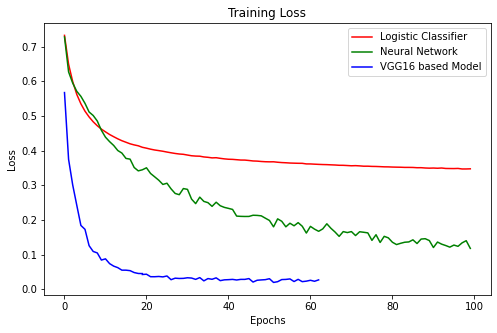

In [65]:
train_loss_fig = plt.figure(figsize = (8,5))
for i, (hist, colour) in enumerate(zip(hist_objs, colours)):        
    y = hist.history['loss']
    if (i==2):
        plt.plot(x2, y, colour)
    elif (i==3):
        plt.plot(x3, y, colour)
    else:
        plt.plot(x1, y, colour)
plt.title("Training Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Logistic Classifier', 'Neural Network', 'VGG16 based Model'], loc='upper right')
plt.show()

### Plotting Validation Loss

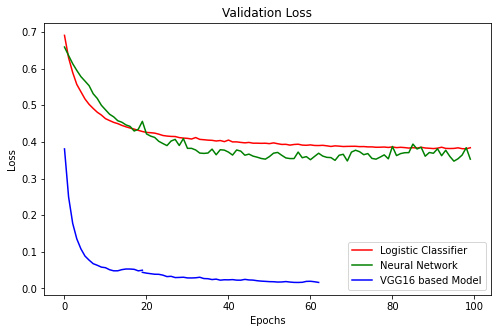

In [66]:
val_loss_fig = plt.figure(figsize = (8,5))
for i, (hist, colour) in enumerate(zip(hist_objs, colours)):         
    y = hist.history['val_loss']
    if (i==2):
        plt.plot(x2, y, colour)
    elif (i==3):
        plt.plot(x3, y, colour)
    else:
        plt.plot(x1, y, colour)
plt.title("Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Logistic Classifier', 'Neural Network', 'VGG16 based Model'], loc='lower right')
plt.show()

### Saving the Plots

In [68]:
train_loss_fig.savefig(os.path.join(imgs_path,"Train-Loss.eps"), format = 'eps')
val_loss_fig.savefig(os.path.join(imgs_path,"Valid-Loss.eps"), format = 'eps')
train_acc_fig.savefig(os.path.join(imgs_path,"Train-Accuracy.eps"), format = 'eps')
val_acc_fig.savefig(os.path.join(imgs_path,"Valid-Accuracy.eps"), format = 'eps')

2020-09-24 15:41:35,914 WARNING The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2020-09-24 15:41:35,914 WARNING The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2020-09-24 15:41:35,942 WARNING The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2020-09-24 15:41:35,943 WARNING The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2020-09-24 15:41:35,967 WARNING The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2020-09-24 15:41:35,967 WARNING The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2020-09-24 15:41:35,994 WARNING The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2020-09-24 15